In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm
#import tqdm
from PIL import Image, ImageEnhance, ImageStat
import copy

***
# Histopathologic Cancer Detection
The following notebook explores the process or preparing, designing and developing a machine learning algorithm for identifying metastatic tissue from a training dataset of histopathologic scans of lymph node sections. This type of research is of particular importance as metastatic cancer is the primary cause of cancer-related deaths. The project and it's data has been prepared and presented by Kaggle, with additional information and project guidance from Kaggle user Joni Juvonen.

Metastatic tissue is defined as cancerous cells that have broken away from their original tumor site and spreading to other parts of the body, a process known as **metastasis**. In most cases, the original cancerous tumor (primary tumor) cells spread through the bloodstream or lymph system, forming secondary tumors in a different location. (National Cancer Institute, n.d.)

!["metastasis.jpg"](assets/metastasis.jpg)<br>Image Source: <a href="https://www.cancer.gov/publications/dictionaries/cancer-terms/def/metastasis">National Cancer Institute</a>

It is worth noting that metastatic tumors *do not* change their respective cancer type merely by spreading to a new location. For example, if a patient has a cancerous tumor in the colon and the cancer spreads to their liver and/or lungs, the secondary tumor is classified as colon cancer that has metastasized in the liver/lungs. It is *not* considered lung cancer.

When cancer is confined to a single primary tumor, once detected it can be surgically removed and/or treated locally to achieve total eradication. Depending on its primary location, for example originating in non-essential organs could spread locally and be treated with complete removal of the organ. Primary tumors are typically only fatal in situations where they arise in essential organs (ie: brain or pancreas) and aggressively spread throughout that organ. Once spread, cancer becomes much more difficult to treat.

Once metastasis has been discovered, cancer cells have already been spreading through the body for some time...each cell with the potential for developing more cancerous tumors throughout the body. It is common for hundreds of metastatic colonies to arise in organs far from the primary tumor. When those colonies grow they have the potential to overwhelm the organ entirely, typically effecting the lungs, liver and bone marrow. A single tumor the size of a grape can spread as many as two million cells into the circulation system in the course of a 24-hour period. (Boston Children's Hospital, n.d.)

Newly formed tumors may remain as small as 1-2 millimeters for years as they develop, which makes finding and tracking the spread of metastatic extremely difficult. Given it's evasive nature, this field of study is well-suited for machine learning algorithms. The small image data used to train this model has been curated and presented by Kaggle, extracted from a set of larger pathology scans

## Project Description
At it's core this project can be boiled down to a binary image classification problem. Sample data is provided in a set of 220,000 96px square images collected from microscope slides prepared with samples of lymph node tissue that has been stained using the hematoxylin and eosin (H&E) method. 

The hematoxylin (dark blue in color) binds to nucleic acids, found predominately in the nuclei of cells, while the eosin (pink in color) binds to a cell's cytoplasm and extracellular parts. See the images below for examples of three decreasing concentrations of metastasized cancer cells in similar stained samples.

!["metastasis_example2.jpeg"](assets/metastasis_example2.jpeg)<br>Image Source: <a href="https://academic.oup.com/gigascience/article/7/6/giy065/5026175">GigaScience, Volume 7, Issue 6, June 2018</a>

While these samples may seem pretty clear to identify, this type of visual identification can be *extremely difficult*. Researchers and clinicians are trained to identify metastatic tissue with the following guidelines:
- Foreign cell population
    - Primary emphasis
    - Typically located in subcapsular sinuses (outer layer of the lymph node)
- Cells with cytologic features of malignancy
    - Nuclear pleomorphism (variation in size, shape and staining)
    - Nuclear atypia, characterized by:
        - Nuclear enlargement
        - Irregular nuclear membrane
        - Irregular chromatin pattern (asymmetry)
        - Large or irregular nucleosus
    - Abundant mitotic figures
- Cells in architectural arrangements seen in malignancy (highly variable, depends on type tumor type and differentiation)
    - Gland formation
    - Single cells
    - Small clusters of cells

(Sloothaak, DA.; Grewal, S.; Doornewaard, H.; van Duijvendijk, P.; Tanis, PJ.; Bemelman, WA.; van der Zaag, ES.; Buskens, CJ. (May 2014))

The lymph nodes are typically one of the first places that breast cancer metastasizes, which makes a collection of this type of tissue a great dataset for study. Traditional histological assessment involves hours of meticulous visual comparison, particularly susceptible to human error. Our model leverages the aforementioned training set to identify metastatic cancer cells in a collection of 57,000 evaluation images. See below for a non-annotated image of breast carcinoma found in a lymph node slide, prepared using the H&E staining method.

!["BreastCarcinoma.jpg"](assets/BreastCarcinoma.jpg)<br>Image Source: <a href="https://commons.wikimedia.org/wiki/User:Nephron">Michael Bonert</a>

Both the training and evaluation sets exhibit roughly a 1:1 ratio of negative to positive test results, though it must be stated that our particular model will focus only on a central portion of each image. While there may be metastatic tissue *outside the bounds of our target area*, such cases will still produce a negative result in our study. For the purpose of this study, a positive result is classified as the presence of **at least one pixel of tumor tissue** present in the 32px square central region of a slide.

### Project Evaluation
The Kaggle guidelines state that the models developed will be evaluated using the **area under the ROC curve**, to determine the performance of a binary classification model. The ROC (receiver operating characteristic) curve, plainly stated, is a direct comparison between the *true positive rate* (TPR) and the *false positive rate* (FPR). 

!["Roc_curve.png"](assets/Roc_curve.png)<br>Image Source: <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:Roc_curve.svg">cmglee, MartinThoma</a>

The image above shows a few sample ROC curves, with the best performing classifier skewing further towards the point (0,1) on the graph. A *perfect* classifier would pass through this point and would exhibit 100% accuracy, which would result in no false-negatives nor false-positives.

# Model Architecture
Admittedly, I am largely unfamiliar with Python ML libraries and was unsure of where to begin with selecting a model architecture. Luckily I was able to narrow my search to PyTorch and TensorFlow thanks to suggestion from a data scientist friend of mine. While both are typically found in most all 'top Python ML libraries' lists, it would seem that PyTorch is renowned for its performance with large, dense data sets like those seen in computer vision or natural language processing. 

!["PyTorch_TensorFlow2.png"](assets/PyTorch_TensorFlow2.png)<br>Image Source: <a href="https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/">(AssemblyAI, 2023)</a>

As we can see, the two frameworks are incredibly popular in practice today resulting in both having large communities and extensive documentation, simplifying implementation and debugging. It would seem, however, that PyTorch is currently the most popular between the two.

!["PyTorch_TensorFlow1.png"](assets/PyTorch_TensorFlow1.png)<br>Image Source: <a href="https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/">(AssemblyAI, 2023)</a>

Given this was my first experience with machine learning libraries, I wanted to simplify the approach as much as possible...ultimately settling on PyTorch for this project. Chosen for its popularity and relatively easy learning curve, when compared to TensorFlow. PyTorch is known for its dynamic computation graph, making the process more intuitive and flexible in use. In general, PyTorch seems to be preferred in research and experimentation.

In contrast, TensorFlow leverages a static computation graph which makes complete graph definition required prior to running. Some users claim this results in a steeper learning curve offset by the ability to optimize models for their performance. In general, TensorFlow seems to be preferred for production and large-scale industry solutions.

## Exploratory Data Analysis
The first step to understanding our specific task is to explore the data we have been provided. We begin by collecting our data and providing some preliminary information from our dataset, as well as providing some visual examples of both positive and negative results. 

In doing so, we get a feel for the distribution of our training data and visually see what our model will be dealing with. With additional time, it may be necessary to analyze average image metrics (brightness, contrast, etc) to determine if any images are of poor visual quality. That said, if an image is of substantially poor quality a negative result would likely be returned on manual inspection as well...unless poor performance is found, intervention may be unnecessary.

In [12]:
# load our data sets for manipulation...
data = pd.read_csv('train_labels.csv')
train_path = 'train/'
test_path = 'test/'

# print out the head of our training labels to see what we are dealing with...
data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [13]:
# return the overall dimensions of our dataset...
data.shape

(220025, 2)

In [14]:
# return the counts of each classification to get a feel for outcomes...
data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [15]:
# check for duplicates, should be all false...
duplicates = data.duplicated()
duplicates.value_counts()

False    220025
Name: count, dtype: int64

Let us define a function for converting an arbitrary image to a numpy array that functions mostly as a matrix would. With rows and columns representing individual pixels of the image, with each cell containing the pixels individual RGB values. I have opted for using the Python imaging library Pillow, as their image processing returns an array presorted in RGB order. Other libraries, like CV2 return them in BGR order and there is no need to introduce additional complexity at this point.

Once defined, we will proceed to print out a random sampling of images from our training set to be rendered side by side for comparison. We will see the overall image, as well as the area of focus for our models, complete with axis for the respective pixel indices. The code for this was developed using Jon Juvonen's submission as reference, it has been repurposed and optimized to suit my style and preferences.

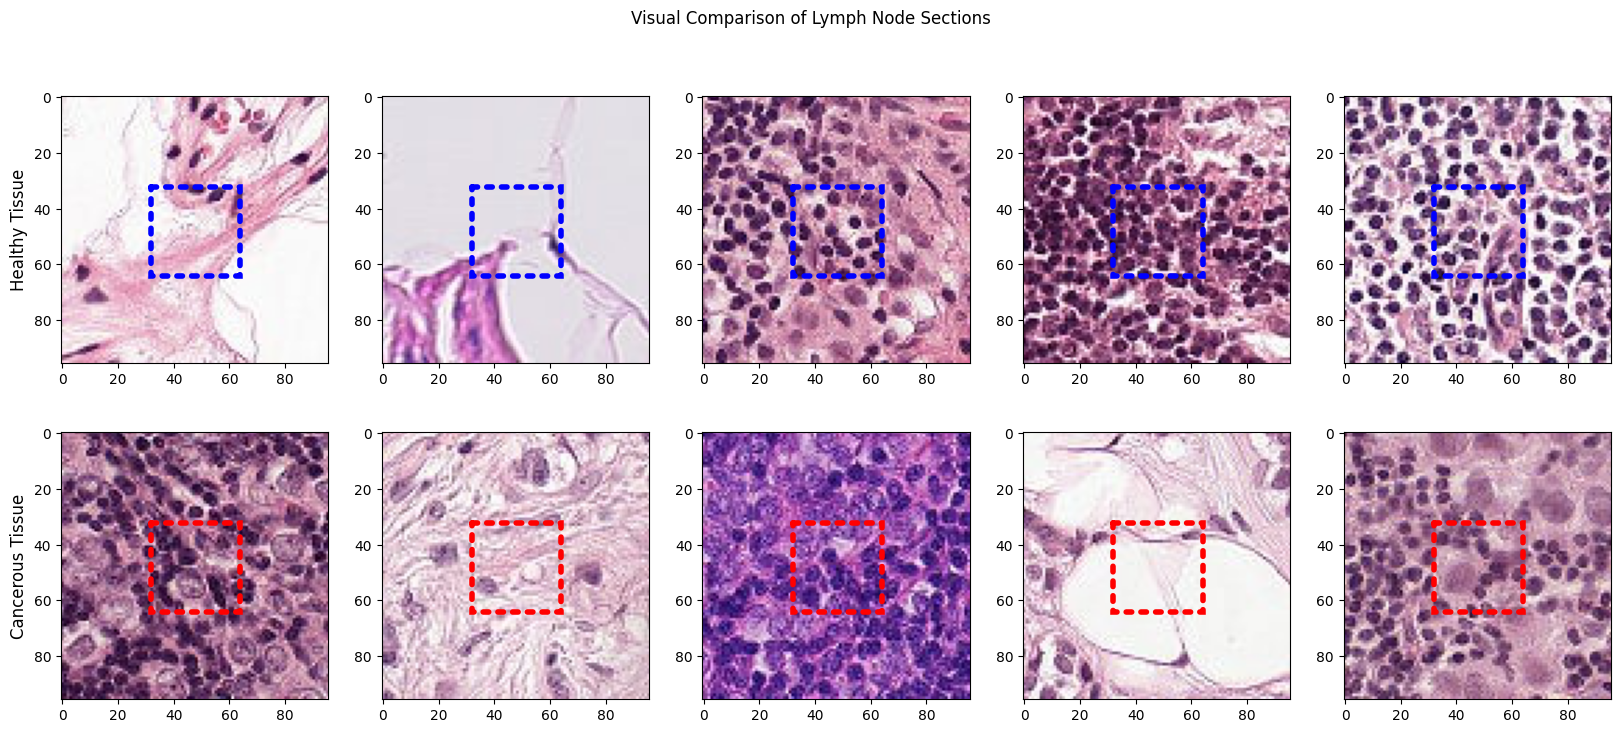

In [16]:
# read in an image using cv2, defaults to BGR order, to be transformed to RGB...
def readImage(path):
    # load in image file to array...
    bgr_img = cv2.imread(path)
    # split into R,G and B values...
    b,g,r = cv2.split(bgr_img)
    # merge into RGB ordered array...
    rgb_img = cv2.merge([r,g,b])

    return rgb_img

# read in an image using pillow, defaults to RGB...
def read_image(path):
    img = Image.open(path).convert('RGB')
    rgb_array = np.array(img)
    return rgb_array

def generateComparison(data):
    def imageArray(data,label,index,color):
        for i, idx in enumerate(data[data['label'] == index]['id'][:5]):
            path = os.path.join(train_path,idx)
            ax[index,i].imshow(read_image(path + '.tif'))

            box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor=color,facecolor='none',linestyle=':',capstyle='round')
            ax[index,i].add_patch(box)

        ax[index,0].set_ylabel(label,size='large')

    shuffled_data = shuffle(data)

    fig,ax = plt.subplots(2,5,figsize=(20,8))
    fig.suptitle('Visual Comparison of Lymph Node Sections')

    imageArray(shuffled_data,'Healthy Tissue',0,'b')
    imageArray(shuffled_data,'Cancerous Tissue',1,'r')

generateComparison(data)

## Training Set Augmentation
In an attempt to minimize overfitting, our model will attempt to fortify our training data through a set of allowable translations to the test samples. If no manipulations were done to our sample images, our model very well may grow accustomed to the size, orientation, coloring of the test images. All of which are variable across the particular thyroid biopsy sample, the slide preparation, and many other variables we do not have access nor knowledge of.

We will augment our given dataset by introducing random translations to images to diversify the sample dataset, thereby minimizing the models tendency to grow accustom to training on the same samples over and over. Such translations include image rotations ($90\degree$ increments), image reflection (both horizontal and vertical), and brightness/contrast manipulation. The list of translations artificially recreates variable processing techniques like thyroid sample thickness, orientation, etc.

In [17]:
# applies random augmentation to training dataset, if time play with other PIL.ImageEnhance qualities...
def augmentImage(image, verbose=False):
    ROTATE = True
    FLIP = True
    BRIGHTNESS = True
    CONTRAST = True
    SHARPNESS = False # this seems to drop scores...
    SPIN = False # this and sharpness dropped scores by 0.02...

    # sample random brightness transformation, validate image mean brightness is acceptable before editing...
    brightness = None
    if BRIGHTNESS:
        brightness = random.uniform(0.75,1.5)
        curr_bright = ImageStat.Stat(image.convert('L')).mean[0]
        
        if(curr_bright * brightness < 230):
            image = ImageEnhance.Brightness(image)
            image = image.enhance(brightness)

    # sample random contrast transformation...
    contrast = None
    if CONTRAST:
        contrast = random.uniform(0.5,1.5)
        image = ImageEnhance.Contrast(image)
        image = image.enhance(contrast)

    # sample random sharpness transformation...
    sharpness = None
    if SHARPNESS:
        sharpness = random.uniform(0.9,1.5)
        image = ImageEnhance.Sharpness(image)
        image = image.enhance(sharpness)

    spin = None
    if SPIN:
        spin = random.randint(0,359)
        image = image.rotate(spin)

    # convert image to numpy array for further translations...
    rgb = np.array(image)

    # sample random left/right turning (whole 90s)...
    rotation = None
    if ROTATE:
        rotation = random.randint(0,2)
        rgb = np.rot90(rgb,k=rotation)

    # sample random image reflection...
    horizontal = None
    vertical = None
    if FLIP:
        horizontal = random.randint(0,1)
        vertical = random.randint(0,1)

        if horizontal:
            rgb = np.flipud(rgb)

        if vertical:
            rgb = np.fliplr(rgb)
        

    # set annotation boolean to turn on annotations for testing purposes...
    if verbose:
            print("\tbrightness: {}".format(brightness))
            print("\tcontrast: {}".format(contrast))
            print("\tsharpness: {}".format(sharpness))
            print("\trotation: {}".format(rotation))
            print("\thorizontal flip: {}".format(horizontal))
            print("\tvertical flip: {}".format(vertical))

    return rgb


	brightness: 1.1463853866631766
	contrast: 0.6009629960168454
	sharpness: None
	rotation: 0
	horizontal flip: 1
	vertical flip: 0
	brightness: 1.461364280520585
	contrast: 1.3153439307754793
	sharpness: None
	rotation: 2
	horizontal flip: 1
	vertical flip: 1
	brightness: 1.1919261345745236
	contrast: 0.9634937603676428
	sharpness: None
	rotation: 0
	horizontal flip: 1
	vertical flip: 1
	brightness: 1.297672117783908
	contrast: 1.0213834933702772
	sharpness: None
	rotation: 2
	horizontal flip: 1
	vertical flip: 0
	brightness: 1.3982471172018984
	contrast: 1.0441833097305824
	sharpness: None
	rotation: 1
	horizontal flip: 0
	vertical flip: 0


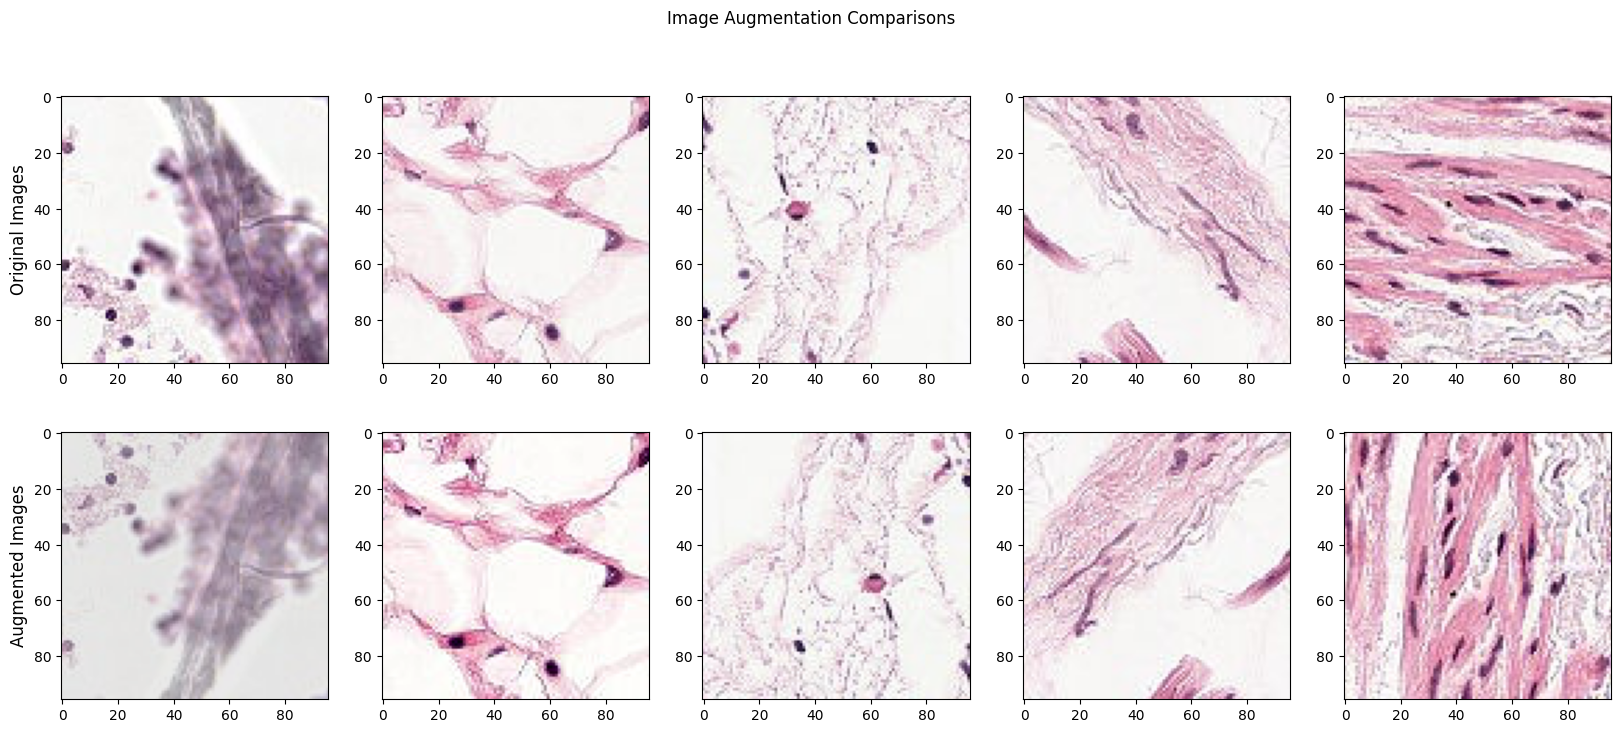

In [18]:
# randomly choose 5 images to render original vs augmented versions...
def testAugmentation(data):
    def imageArray(data,label,index,case,augment):
        for i, idx in enumerate(data[data['label'] == case]['id'][:5]):
            path = os.path.join(train_path,idx)
            if augment:
                #print("editing image {}:".format(i))
                image = Image.open(path + '.tif').convert('RGB')
                image = augmentImage(image,True)
            else:
                image = read_image(path + '.tif')

            ax[index,i].imshow(image)

        ax[index,0].set_ylabel(label,size='large')

    shuffled_data = shuffle(data)

    fig,ax = plt.subplots(2,5,figsize=(20,8))
    fig.suptitle('Image Augmentation Comparisons')

    imageArray(shuffled_data,'Original Images',0,0,False)
    imageArray(shuffled_data,'Augmented Images',1,0,True)

testAugmentation(data)


## Defining the Dataset
The following code block imports the pertinent PyTorch modules/libraries we will be implementing in our training, followed by a custom class definition for our custom dataset (inherits from `torch.utils.data.Dataset`).

During initialization, the data URL is assembled and the data source is sampled. The full file names, image file labels (sans file extensions), and our current transformation functions are stored in our class definition. The rest is pretty straight-forward, with processes for finding the size of the dataset and selecting/editing a photo at a given index.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import utils
#from torchsummary import summary
import torchinfo
import timm
import seaborn as sns

torch.manual_seed(0)

class CancerScreening_Dataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # assemble data_dir with data_type, ie: './train'...
        cwd = os.path.join(data_dir,data_type)

        # generate list of files from working directory provided...
        file_names = os.listdir(cwd)

        # pull 4000 file indices at random...
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      4000, 
                                      replace=False)

        # store the indexed file names for storing into the class definition...
        file_names_sample = [file_names[x] for x in idx_choose]

        # store the indexed files in the class definition...
        self.full_filenames = [os.path.join(cwd,f) for f in file_names_sample]

        # set './train_labels.csv' as cwd...
        labels_data = os.path.join(data_dir, "train_labels.csv")

        # read labels into numpy array...
        labels_df = pd.read_csv(labels_data)

        # set numpy array index to 'id'...
        labels_df.set_index("id", inplace=True)

        # sets class labels from list of file names sans extensions to class definition...
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]

        # sets specified transform to class definition...
        self.transform = transform

    # return length of dataset...
    def __len__(self):
        return len(self.full_filenames)
    
    # return a tuple of transformed image and respective label...
    def __getitem__(self,idx):
        # load in an image from the classes file names...
        image = Image.open(self.full_filenames[idx]).convert('RGB')

        # apply random augmentations defined above, copy to reset array stride to positive...
        image = augmentImage(image).copy()

        # apply Tensor transforms for image processing...
        image = self.transform(image)

        return image, self.labels[idx]

Notice how in `__getitem__()` both our custom augmentation function and the stored class transform functions are being used. In this case, the latter is being used devoid of any real transformations...it was merely being used to ensure that our NumPy array image was being presented in the correct format.

The following segment explores both PyTorch's native image transformations, as well as my custom image transformations. In many cases, the outcomes are comparable. In others, the fine-tuned adjustments and bound setting allows for the images produced through my custom scripts to be more consistently high-quality than the native ones. That said, this may be entirely to blame based on my lack of experience using PyTorch.

### Building the Training Dataset
Now that our dataset class definition is complete, we can move ahead with generating it. Once defined, we run a gut check print-statement to ensure that our dataset is what we expected.

In [20]:
# converts numpy array into PyTorch tensor with pixel values [0,1] and resizes image to 46 x 46... 
data_transformer = transforms.Compose([transforms.ToTensor()])#,transforms.Resize((46,46))]) # provides 14px border around test area for context...

# define a new training dataset...
img_dataset = CancerScreening_Dataset('./', data_transformer, "train")

img,label = img_dataset[10]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.1765) tensor(0.9255)


In [21]:
''' bar graphs take a long time to process, turned off for now...
# Check the distribution of classes in the training dataset
train_labels = [label for _, label in img_dataset]
sns.countplot(x=train_labels)
plt.title('Class Distribution in Training Set')
plt.show()
'''

" bar graphs take a long time to process, turned off for now...\n# Check the distribution of classes in the training dataset\ntrain_labels = [label for _, label in img_dataset]\nsns.countplot(x=train_labels)\nplt.title('Class Distribution in Training Set')\nplt.show()\n"

# Training the Model
In order to evaluate the performance of our model in the training phase, it is necessary to split our training dataset into a true **training set** and a **validation set** (`train_ts` and `val_ts`). 

This allows for training our model on the majority (80%) of our data, while leaving the remainder of the *known* training data for evaluating the performance of our model before implementation.

In [22]:
db_size = len(img_dataset)
train_size = int(0.8 * db_size)
val_size = db_size - train_size

print("training dataset size: {}".format(train_size))
print("validation dataset size: {}".format(val_size))

# split the PyTorch tensor dataset into training and validation sets...
train_ts, val_ts = random_split(img_dataset, [train_size,val_size])

training dataset size: 3200
validation dataset size: 800


Again, we will perform a gut-check and validate the first few entries of our dataset. Printing out the shape/size of the training image and it's respective value.

In [23]:
# generate the torch tensor image and target variables...
ii = 0
for x,y in train_ts:
    print("x.shape:",x.shape,"y:",y)
    ii += 1
    if(ii > 4):
        break

x.shape: torch.Size([3, 96, 96]) y: 1
x.shape: torch.Size([3, 96, 96]) y: 1
x.shape: torch.Size([3, 96, 96]) y: 0
x.shape: torch.Size([3, 96, 96]) y: 0
x.shape: torch.Size([3, 96, 96]) y: 0


### Validating Image Augmentation and Data Splitting
The following steps have accomplished a lot, and it is worth the time to ensure that everything we have done is implemented correctly. 

The function below creates a grid of thirty (30) randomly selected samples from both training and validation sets, optionally applies augmentations and renders them side-by-side with their respective status.

image indices: [1639 1283  460  462  838 2806  670 2338 2711 1872 2081  717 2224 1214
 2277 2848  904 2002 2912  161  942 2309  783 1397 1552 1178 3182  979
 2279 2224]
image indices: [484 669 184 569 460 484 382 276  36 267 385 748 312 222 568  43 663 680
 590 182 331 731 199 133  69 142 533 622 628 677]


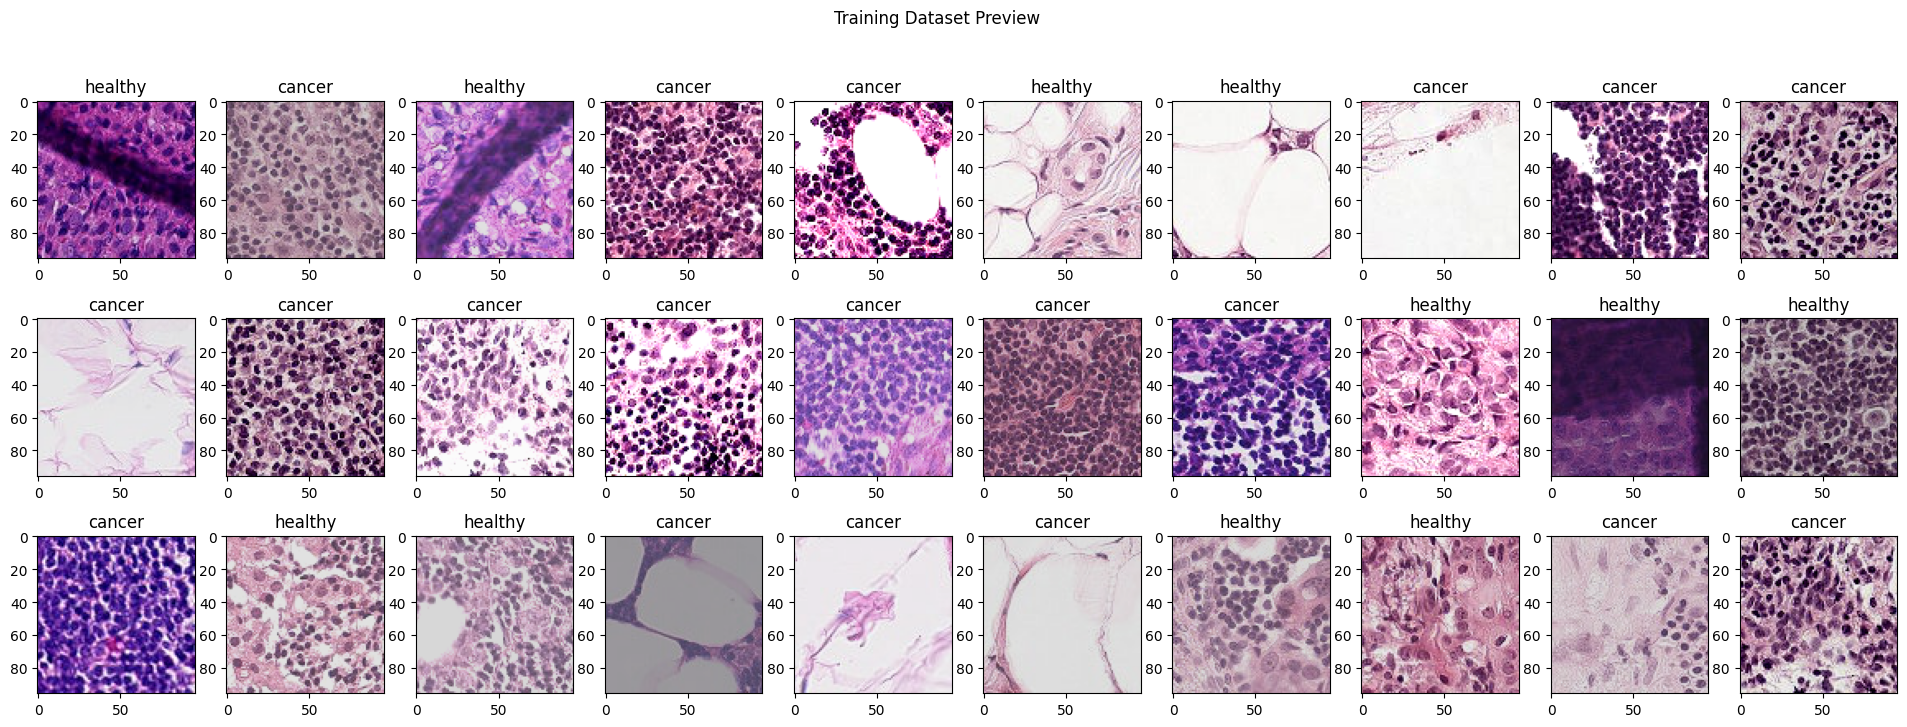

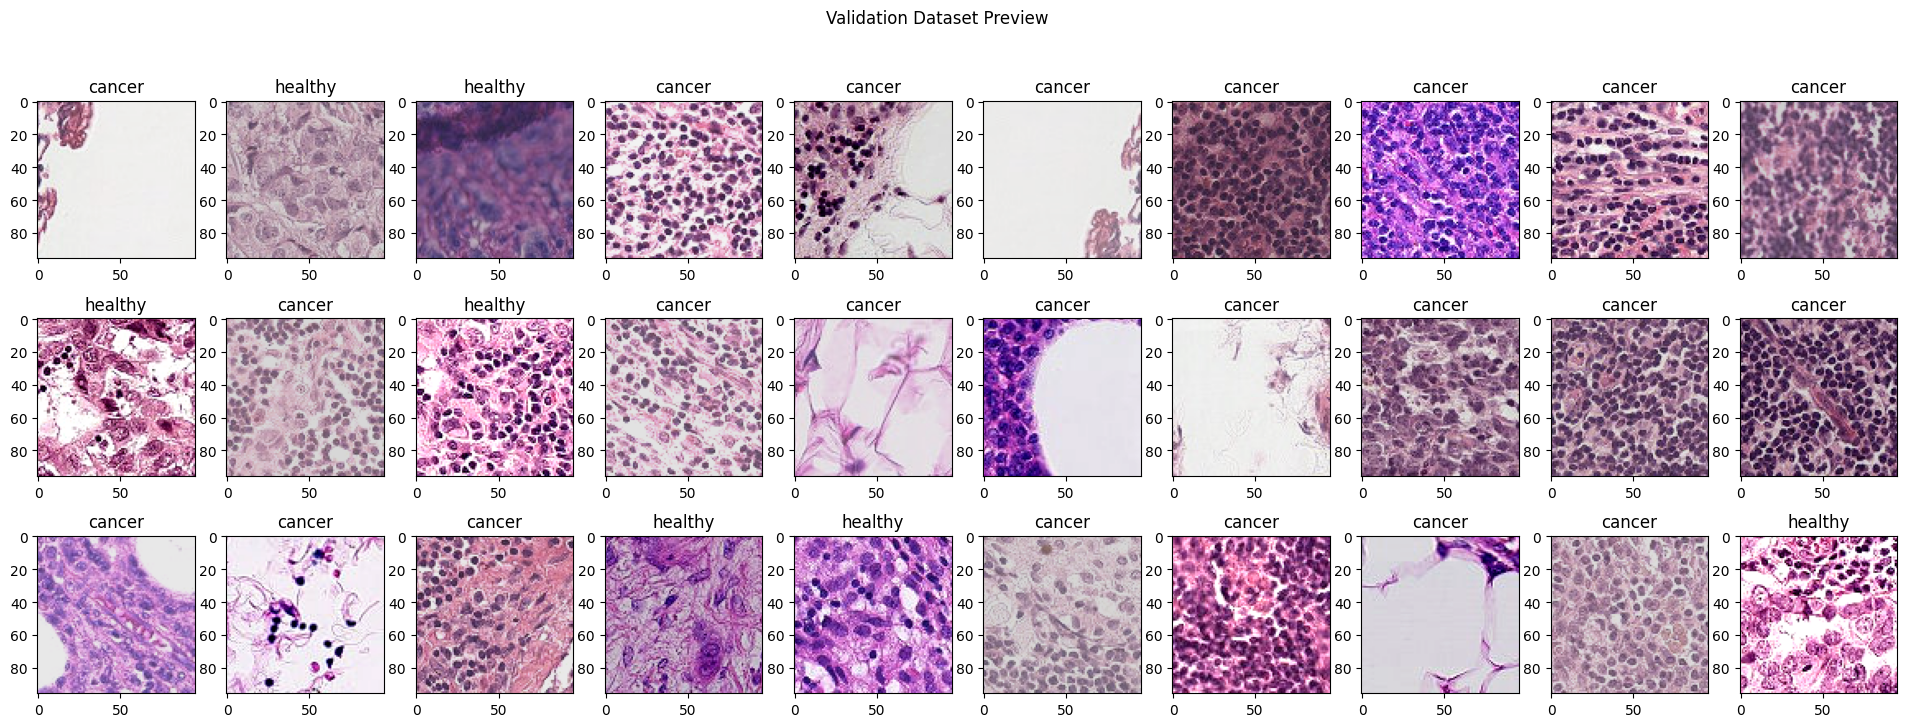

In [24]:
def previewDataset(data,title):
    rows = 3
    cols = 10

    rnd_inds = np.random.randint(0,len(data),rows*cols)
    print("image indices: {}".format(rnd_inds))

    x_grid_train = [data[i][0] for i in rnd_inds]
    y_grid_train = [data[i][1] for i in rnd_inds]

    fig,ax = plt.subplots(rows,cols,figsize=(24,8))
    fig.suptitle(title)

    ind = 0
    for i in range(rows):
        for j in range(cols):
            image = transforms.functional.to_pil_image(x_grid_train[ind])
            #image = augmentImage(image)
            ax[i,j].imshow(image)
            ax[i,j].set_title("cancer" if y_grid_train[ind] == 0 else "healthy")
            
            ind += 1

previewDataset(train_ts,"Training Dataset Preview")
previewDataset(val_ts, "Validation Dataset Preview")


### Finalizing Image Augmentations
As I was working through this portion of the project, I learned of PyTorch's native library of image transform tools. For reference purposes; I have included the PyTorch library methods below, though I will attempt to use the image augmentation functions defined in the previous sections.

To plug my original augmentation function into the dataset's transformation function class definition, `.transform`, the original function needs to transform to PIL for augmentation then from numPy array to Tensor. While my original plan is to implement my original augmentations, I will ultimately implement the package that performs the best. 

In practice, I found that the PyTorch native image transformations are convenient, but fail to achieve the same customization and throttling (for lack of a better term) as my custom methods.

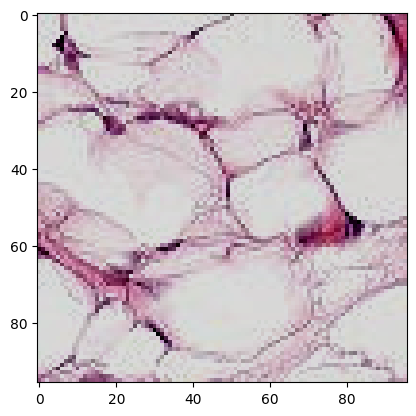

In [25]:
def returnImage(image):
    return image

def transformImage(image):
    image = transforms.functional.to_pil_image(train_ts[0][0])
    image = augmentImage(image).copy()

    return torch.from_numpy(image)

image = transformImage(train_ts[0][0])
plt.imshow(image)

train_ts.transform = transformImage
val_ts.transform = returnImage

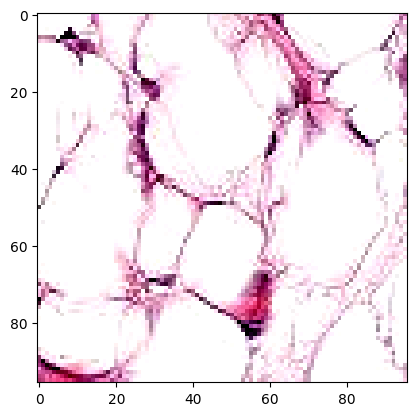

In [26]:

seed = random.randint(0,3)

tr_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter((0.75,1.2),(0.5,1.3)),
    #transforms.RandomRotation(180)
])

#train_ts.transform = tr_transform
#val_ts.transform = tr_transform # not needed...

img = tr_transform(train_ts[0][0])
plt.imshow(img.permute(1,2,0))

### Creating Dataloaders
Generate and verify correct definitions for PyTorch dataloaders, which are key utilities for managing data during training and validation.

The following code block implements the PyTorch `DataLoader` module; taking as input the respective dataset (training vs validation), batch size (ie: number of samples per batch) and a boolean for shuffling. It is advisable to work in 'mini-batches' as it helps to stabilize the learning process and is often more efficient than updating the model after every sample.

In [27]:
train_dl = DataLoader(train_ts, batch_size=32, shuffle=True)

val_dl = DataLoader(val_ts, batch_size=32, shuffle=False)

Once again, we verify our work so far. We print the data presented to us above, validating that there are 32 images with 32 records attributed to them. According to <a href="https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU">Weights & Biases</a> the batch size of 32 typically provides the best results/computation time returns.

In [28]:
for x,y in train_dl:
    print("x.shape:",x.shape,"y:",y)
    break

x.shape: torch.Size([32, 3, 96, 96]) y: tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0])


### Define Binary Classifier
The following class definition was modeled after the Kaggle competition entry from Andrey Shtrauss, which is composed of:
- Four (4) CNN Conv2D layers with a pooling layer max_pool2D added between each layer
- Two (2) fully connected layers fc, with a dropout layer between the two layers
- log_softmax is used as the activation function for the final layer of the binary classifier

Using the helper `findConv2dOutShape()` we unpack the convolution layer parameters and calculate the output shape of the 2D convolutional layer, and optionally run the results through a pooling operation. `hout` and `wout` are originally derived using the standard formula for convolutional layers. Returning the height and width of the convolutional layer in integers.

#### Initialization
The aforementioned helper will be used in our `Network` class definition below it. The initialization begins by collection parameters from the input parameter dictionary/model; such as the input shape, number of initial filters, size of the first fully connected layer, number of output classes, and the dropout rate. 

To form the **four (4) convolutional layers**, each layer is iteratively derived from the first layer...which itself was generated from our initial inputs. Once the layer is generated and stored in the class, we use our helper to grab the resulting layer shape/size to be used in the following layer. The flattened feature map is calculated from the dimensions of the final convolutional layer and number of initial filters. At which point we define **two (2) fully connected layers** to be stored in the class as well.

#### Applying Layers
The next class function `forward()` defines the forward pass of our networks. Each convolutional layer applies a ReLU activation and max pooling operation are performed before they are collectively flattened. Of which is implemented to apply the fully connected layers with their own ReLU activation and dropouts, respectively. The final output is passed using **log_softmax**.

In general, the class instantiates a neural network model, to be trained and evaluated with PyTorch's training loop. The helper function merely is implemented to avoid tedious code and potential error with each iteration, ensuring the dimensions of the feature maps are correct.

In [29]:
def findConv2dOutShape(hin,win,conv,pool=2):
    #print("hin: {}, win: {}".format(hin,win))
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    hout = np.floor( (hin+2*padding[0] - dilation[0]*(kernel_size[0]-1)-1) / stride[0]+1 )
    wout = np.floor( (win+2*padding[1] - dilation[1]*(kernel_size[1]-1)-1) / stride[1]+1 )

    if pool:
        hout = np.floor((hout - 1) / pool + 1)
        wout = np.floor((wout - 1) / pool + 1)
    
    return int(hout),int(wout)

# neural network class definition...
class Network(nn.Module):
    # network initialization...
    def __init__(self,params):
        super(Network, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        #print("Cin: {}, Hin: {}, Win: {}".format(Cin,Hin,Win))
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # convolution layers...
        #self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, padding=1)
        h,w = findConv2dOutShape(Hin, Win, self.conv1)

        #self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, padding=1)
        h,w = findConv2dOutShape(h, w, self.conv2)

        #self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
        h,w = findConv2dOutShape(h, w, self.conv3)

        #self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3, padding=1)
        h,w = findConv2dOutShape(h, w, self.conv4)

        # compute the flatten size...
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        # convolution and pool layers...
        X = nn.functional.relu(self.conv1(X))
        X = nn.functional.max_pool2d(X, 2, 2)

        X = nn.functional.relu(self.conv2(X))
        X = nn.functional.max_pool2d(X, 2, 2)

        X = nn.functional.relu(self.conv3(X))
        X = nn.functional.max_pool2d(X, 2, 2)

        X = nn.functional.relu(self.conv4(X))
        X = nn.functional.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = nn.functional.relu(self.fc1(X))
        X = nn.functional.dropout(X, self.dropout_rate)
        X = self.fc2(X)

        return nn.functional.log_softmax(X, dim=1)

Using the `Network` class, we define our parameter model and generate our neural network (printed for reference). Next, the computation device is declared...in our case, we would prefer to use *cuda* but for flexibility check down to *cpu* where needed.

In [30]:
# neural network predefined parameters...
params_model = {
    "shape_in": (3,96,96),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}

# create instantiation of network class...
cnn_model = Network(params_model)
print(cnn_model)

# define computation hardware approach (GPU/CPU)...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

Network(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


Using the `torchinfo.summary` module, we can present our network in a much better format. 

In [31]:
torchinfo.summary(cnn_model, input_size=(3,96,96), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 2]                    --
├─Conv2d: 1-1                            [8, 96, 96]               224
├─Conv2d: 1-2                            [16, 48, 48]              1,168
├─Conv2d: 1-3                            [32, 24, 24]              4,640
├─Conv2d: 1-4                            [64, 12, 12]              18,496
├─Linear: 1-5                            [1, 100]                  230,500
├─Linear: 1-6                            [1, 2]                    202
Total params: 255,230
Trainable params: 255,230
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 19.07
Input size (MB): 0.11
Forward/backward pass size (MB): 1.11
Params size (MB): 1.02
Estimated Total Size (MB): 2.24

### Loss Function Definition
Loss functions are crucial in deep learning as they guide how PyTorch updates a network to achieve its goals. For classification tasks, the common choice is cross-entropy loss (or log loss). When setting up a loss function, it's important to consider the number of outputs and their activation functions. 

In binary classification, one or two outputs may be used, with log_softmax being preferred due to its numerical stability and efficiency. This function integrates both logarithm and softmax operations, facilitating a smoother transition to multiclass classification tasks.

In [32]:
loss_func = nn.NLLLoss(reduction="sum")

### Optimizer Definition
Training a neural network involves passing data through the network, using a **loss function** to measure the difference between the predicted and true values. This difference informs the adjustment of the network's weights to minimize the loss function. To achieve this, an **optimizer** is employed to update the network's parameters based on computed gradients. 

PyTorch’s torch.optim module includes implementations of various optimizers, which maintains the current state and adjust parameters accordingly. For binary classification tasks, optimizers such as SGD and Adam are commonly used, with Adam being selected for this case.

In [33]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
#opt = optim.Adam(cnn_model.parameters(), lr=0.01)
#opt = optim.Adam(cnn_model.parameters(), lr=1e-3)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

c:\Users\camer\Documents\CU-Boulder\CSPB 3202 - Artificial Intelligence\CancerDetection\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Setting the Model
Defining several helper functions and setting the params train for input in our model.

#### Gathering the Learning Rate
The first, `get_lr()`, simply pulls the **learning rate** from the optimizer. This information can be used for tracking/debugging during training, especially when the learning rate schedulers manipulate the learning rate over time.

#### Batch Loss/Accuracy
The second, `loss_batch()`, computes the loss and accuracy for a batch of data...optionally, it may perform a backward pass and optimization step. If an optimizer is provided, it will also update the model parameters based on the computed gradients. 

It leverages the provided loss function to compute it's loss, while the accuracy is derived by comparing the predicted labels (using `.argmax()`) with the true labels. It returns a tuple consisting of the loss and the number of correct predictions for the batch.

#### Epoch Loss/Accuracy
The third, `loss_epoch()`, computes the average loss and accuracty for an entire pass through the training and validation dataset (ie: an entire epoch). Initial values are set for the running loss and total number of correct predictions (`run_loss` and `t_metric`) before iterating *all* batches of data. 

During iteration, the input and target tensors (`xb` and `yb`) are moved to our specified device (ie: CPU or GPU), the model's output for the current batch (`output`) is collected, and the loss/accuracy (`loss_b` and `metric_b`) for the current batch is collected.

The derived batch data is accumulated into the previously defined variables and averaged before returning.

In [34]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

The following code block features the `params_train` dictionary, which allows for inputting complicated parameter information through a single variable definition.

In [35]:
params_train = {
    "train": train_dl,
    "val": val_dl,
    "epochs": 50,
    "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
    #"optimiser": optim.Adam(cnn_model.parameters(),lr=0.01),
    #"optimiser": optim.Adam(cnn_model.parameters(),lr=1e-3),
    "lr_change": optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0),
    "f_loss": nn.NLLLoss(reduction='sum'),
    "weight_path": "weights.pt",
    "check": False,
}

# Training the Model
The following function trains and validates our PyTorch model over the course of a specified number of epochs. It takes as argument; our model, the parameters dictionary, and the boolean *verbose*.

It begins by extracting the host of parameters taken as input; number of epochs, loss function, optimizer, training and validation dataloaders, learning rate scheduler and the path to save our best model to. It then works to initialize the loss history, metric history, best model and best loss; explained further below:
- `loss_history`: Dictionary to store training and validation loss values for each epoch
- `metric_history`: Dictionary to store training and validation metric values for each epoch
- `best_model_wts`: Stores a deep copy of the model's state dictionary to keep track of the best performing model
- `best_loss`: Initialized to infinity to track the lowest validation loss

### Training Loop
The library `tqdm` is used to impart a visual progress bar, tracking the progress/iterations of our training loop. 

#### Get Learning Rate
The first step is to use `get_lr` to grab the current learning rate, presenting a format string if *verbose* bool is provided. Next, set the model to **training mode** and compute the **training loss** and **metric** for the current epoch...appending thier results to their respective history dictionaries formatted earlier.

#### Evaluation
Set the model to **evaluation mode** and find the loss/metric using `torch.no_grad` to disable the gradient computation. Verify if the current loss is the current minimum/best, and if so, update `best_loss` and `best_model_wts` and save a copy to variable `weight_path`. If *verbose*, alert that a model has been copied. In any case, the weights are logged and the loop continues to iterate.

Next, we update the **learning rate scheduler** from our derived **validation loss**; if the rate changes, it will load the best *model weights*. If *verbose*, a message will be printed when the rate changes and a formatted summary of the current epoch is printed prior to returning to the next epoch.

In [36]:
def train_val(model, params,verbose=False):
    # extracting parameters given as input...
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # initialize history and best weights...
    loss_history = {"train": [],"val": []} # history of loss values in each epoch
    metric_history = {"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss = float('inf') # initialize best loss to a large value
    
    # train model for the specified number of epochs...
    for epoch in tqdm(range(epochs)):
        
        # get current learning rate, if verbose print format string...
        current_lr = get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        # train model and compute training loss/metric...         
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect loss/metric and append to resp dict...
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model, get loss/metric...
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model...
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file...
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset...
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # update the learning rate scheduler from val_loss...
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

### Validating the Model
This section begins with another parameter model; dataloader for the training set, dataloader for the validation set, number of epochs to train the model, an optimizer, a learning rate scheduler, loss function and the file path to save the best model weights.

These parameters are used to train and validate our model, with `train_val`. In our case, the training validation function is call with `cnn_model` and trains and validates the model over the specified number of epochs.

The trained model is derived and returned as a tuple complete with; CNN model, our loss history and metric history.

In [37]:
params_train={
    "train": train_dl,
    "val": val_dl,
    "epochs": 50,
    "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
    #"optimiser": optim.Adam(cnn_model.parameters(),lr=0.01),
    #"optimiser": optim.Adam(cnn_model.parameters(),lr=1e-3),
    "lr_change": optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0),
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": "weights.pt",
}

# train and validate the model...
cnn_model,loss_hist,metric_hist = train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [27:09<00:00, 32.58s/it]  


The following commented section were troubleshooting functions/attempts to rectify mismatched input/output model sizes. These can be ignored, but remain for personal reference.

In [55]:
'''
# code for troubleshooting model...
for xb,yb in train_dl:
    print(xb.shape)
    print(yb.shape)

import torch.nn as nn

# Define your model and loss function
model = Network(params_model)  # replace with your model class
loss_func = nn.NLLLoss()  # Ensure this matches your model's output

# Training loop
for xb, yb in train_dl:
    xb = xb.to(device)  # Move to GPU if available
    yb = yb.to(device)
    
    output = model(xb)  # Forward pass
    
    # Check shapes
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {yb.shape}")
    
    # Compute loss
    loss = loss_func(output, yb)
'''

'\n# code for troubleshooting model...\nfor xb,yb in train_dl:\n    print(xb.shape)\n    print(yb.shape)\n\nimport torch.nn as nn\n\n# Define your model and loss function\nmodel = Network(params_model)  # replace with your model class\nloss_func = nn.NLLLoss()  # Ensure this matches your model\'s output\n\n# Training loop\nfor xb, yb in train_dl:\n    xb = xb.to(device)  # Move to GPU if available\n    yb = yb.to(device)\n    \n    output = model(xb)  # Forward pass\n    \n    # Check shapes\n    print(f"Output shape: {output.shape}")\n    print(f"Target shape: {yb.shape}")\n    \n    # Compute loss\n    loss = loss_func(output, yb)\n'

### Visualizing the Model
The following code block plots our training and validation loss and accuracy over the number of training epochs. The *x-axis* was established with `params_train["epochs"]` and the sub-plots were formatted. The loss and accuracy are rendered side by side, to illustrate the convergence behavior of the model.

Generally speaking, training/validation loss should decrease over time while accuracy should increase. This trend indicates that our model is learning effectively, if the plots plateau or diverge it may be an indicaiton of overfitting or underfitting.

When our models are set to plot, we see that as the number of `epochs` pass; we see training and validation loss drop exponentially at first, but settles into a linear decline. The accuracy is the inverse; growing more accurate exponentially, before settling into linear growth. 

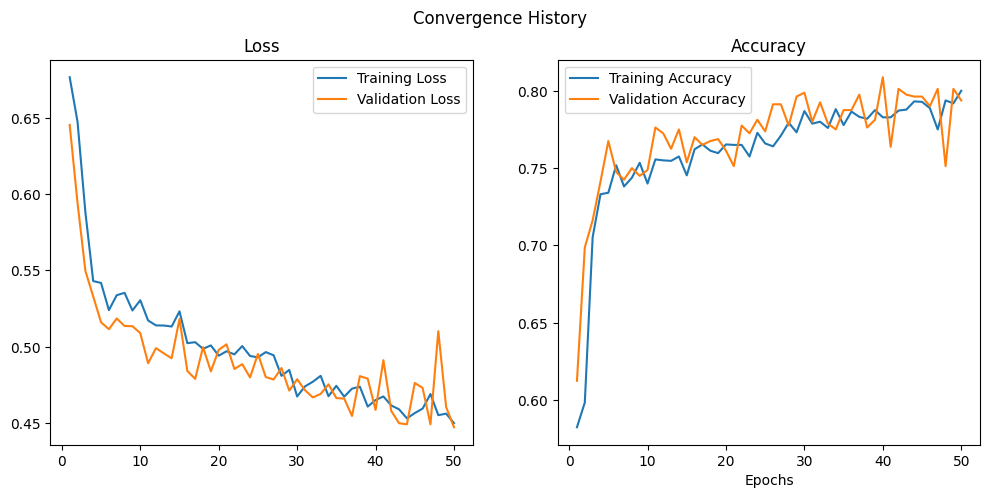

In [56]:
import seaborn as sns;
#sns.set(style='whitegrid')

epochs = params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))
plt.suptitle('Convergence History')
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
plt.xlabel("Epochs")

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='Training Loss')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='Validation Loss')

sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Training Accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Validation Accuracy')

plt.show()

In [57]:
'''
# attempted to get confusion matrix working, but dont have the right data...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test_pred contains the predicted class labels and img_dataset_test.labels contains the true labels
true_labels = [label for _, label in val_ts]

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
'''

"\n# attempted to get confusion matrix working, but dont have the right data...\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\n# Assuming y_test_pred contains the predicted class labels and img_dataset_test.labels contains the true labels\ntrue_labels = [label for _, label in val_ts]\n\n# Compute confusion matrix\ncm = confusion_matrix(true_labels, y_test_pred)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\n\n# Plot confusion matrix\ndisp.plot(cmap='Blues')\nplt.title('Confusion Matrix')\nplt.show()\n"

# Testing the Model
Now that the model has been trained and we have our best model weights saved, we begin preparations to test our model.
### Class Definition
The following class definition is a custom dataset for handling test data in our PyTorch network, as an extension of `torch.utils.data.Dataset`. It takes as argument; the data directory where our data is stored, a set of transformations to be applied to each image and the specification of what purpose the data is being used for.

The first portion constructs the path directory to where the data is being stored, directed by the `data_type` parameter, and stores them all in a list in the class. Next, a Pandas dataframe is generated from the `sample_submission.csv` whose index is set to *id*. The labels from the dataframe are stored in the class definition, as well as the established transformation function.

Just as we saw in our initial setup, the `__len__` and `__getitem__` return the length of our dataset and apply augmentations to the images.

In [58]:
class CancerScreening_Test(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # construct the data directories into a list in full_filenames...
        path = os.path.join(data_dir,data_type)
        filenames = os.listdir(path)
        self.full_filenames = [os.path.join(path,f) for f in filenames]

        # labels are in a CSV file, sample_submission.csv...
        csv_file = "sample_submission.csv"
        csv_path = os.path.join(data_dir,csv_file)
        labels_df = pd.read_csv(csv_path)

        # set dataframe index to id...
        labels_df.set_index("id", inplace=True)

        # store the dataframe labels and transform function...
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform

    # returns the length of the dataset...
    def __len__(self):
        return len(self.full_filenames)
    
    # open image, apply augmentations and return with label...
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

### Function Parameter Dictionary
When training a neural network, it is typical to save the model's parameters (weights and biases) to a file after training. That way they can be reused without the need for retraining.

In [59]:
cnn_model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

### File ID's
The submission file, `sample_submission.csv`, contains all the ID's for the images in the test folder...much like `train_labels.csv` in previous sections.

In [60]:
sub_path = "./sample_submission.csv"
labels_df = pd.read_csv(sub_path)

print(labels_df.shape)
labels_df.head()

(57458, 2)


id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [61]:
print(labels_df['label'].value_counts())
'''
# Check the distribution of classes in the test dataset
test_labels = [label for label in labels_df["label"]]
sns.countplot(x=test_labels)
plt.title('Class Distribution in Test Set')
plt.show()
'''

label
0    57458
Name: count, dtype: int64


'\n# Check the distribution of classes in the test dataset\ntest_labels = [label for label in labels_df["label"]]\nsns.countplot(x=test_labels)\nplt.title(\'Class Distribution in Test Set\')\nplt.show()\n'

### Verifying Image Dataset
Just as before, we will convert and store the image data into Tensor images and define our model class. The `data_transformer` is used in establishing our test model and the resulting model is length verified as a gut-check.

In [45]:
# converts numpy array into PyTorch tensor with pixel values [0,1] and resizes image to 46 x 46... 
data_transformer = transforms.Compose([transforms.ToTensor()])#,transforms.Resize((46,46))]) # provides 14px border around test area for context...

# define a new training dataset...
img_dataset_test = CancerScreening_Test('./', data_transformer, "test")
print(len(img_dataset_test), 'samples found')

57458 samples found


### Prediction Process
The function `inference` performs an inference using our trained PyTorch model on a given dataset, returning the predicted and ground truth labels. It takes as argument; our model, our dataset, the computation device and the number of classes.

It is initialized with:
- `len_data`: The length of the dataset, ie: the number of samples
- `y_out`: A tensor to store the model's output probabilities or scores for each sample. It has a shape of (len_data, num_classes)
- `y_gt`: A NumPy array to store the ground truth labels for each sample
- `model` = model.to(device): Moves the model to the specified device (CPU or GPU)

Next, the inference loop is performed with `torch.no_grad` to disable gradient calculation, saving memory and computations. Another `tdqm` progress bar is used to track our progress, while the $i^{th}$ sample is taken. The sample and its label are retrieved to be stored in a truth table, `y_gt` while a batch dimension is added to the input tensor...moving it to the specified device. 

Finally, the inputs are passed through the model and stored in `y_out`.

In [46]:
def inference(model, dataset, device, num_classes=2):
    len_data = len(dataset)
    y_out = torch.zeros(len_data, num_classes)
    y_gt = np.zeros((len_data), dtype="uint8")
    model = model.to(device)

    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y = dataset[i]
            y_gt[i] = y
            y_out[i] = model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt

The defined `inference` function is called to generate predictions for the provided dataset according to our trained model.

In [47]:
y_test_out,_ = inference(cnn_model, img_dataset_test, device)

  0%|          | 0/57458 [00:00<?, ?it/s]

100%|██████████| 57458/57458 [35:29<00:00, 26.98it/s]  


The first code block converts our model's output probabilities/scores into class predictions. Printing the shape of the predictions array and the first five predictions. The second code block calculates the probabilities of the predicted classes by exponentiating the log-softmax outputs.

In [48]:
# class predictions 0 vs 1...
y_test_pred = np.argmax(y_test_out, axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

(57458,)
[0 1 0 0 0]


In [49]:
# probabilities of predicted selections...
# return F.log_softmax(x, dim=1) ie:
preds = np.exp(y_test_out[:, 1])
print("prediction shape:",preds.shape)
print("prediction sample:",preds[0:5])

prediction shape: (57458,)
prediction sample: [0.4081561  0.58809286 0.4289055  0.03266381 0.02845514]


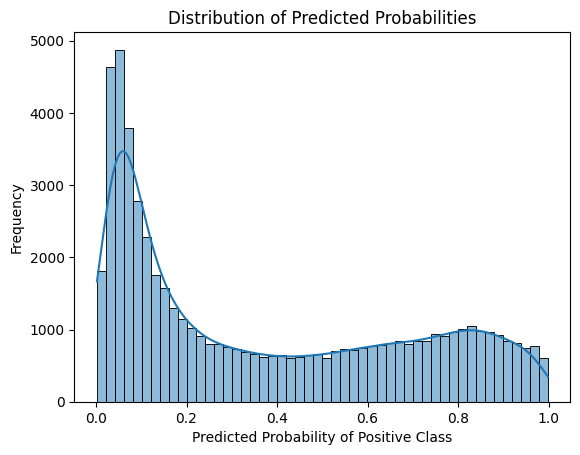

In [50]:
# Plot distribution of predicted probabilities
sns.histplot(preds, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [51]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test_pred contains the predicted class labels and img_dataset_test.labels contains the true labels
true_labels = [label for _, label in img_dataset_test]

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
'''

"\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\n# Assuming y_test_pred contains the predicted class labels and img_dataset_test.labels contains the true labels\ntrue_labels = [label for _, label in img_dataset_test]\n\n# Compute confusion matrix\ncm = confusion_matrix(true_labels, y_test_pred)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\n\n# Plot confusion matrix\ndisp.plot(cmap='Blues')\nplt.title('Confusion Matrix')\nplt.show()\n"

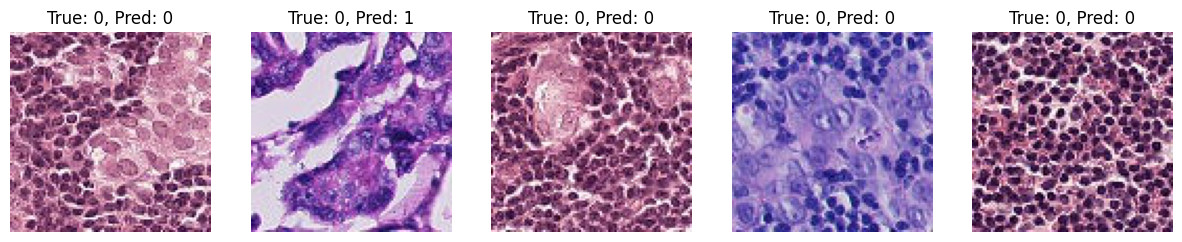

In [52]:
def show_samples(dataset, model, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(img)
            pred = torch.argmax(output, dim=1).item()
        
        img = img.cpu().squeeze().numpy().transpose((1, 2, 0))
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {label}, Pred: {pred}')
        axes[i].axis('off')
    
    plt.show()

# Show sample predictions
show_samples(img_dataset_test, cnn_model, device)

In [53]:
'''
# Check the distribution of classes in the test dataset
test_labels = [label for _, label in img_dataset_test]
sns.countplot(x=test_labels)
plt.title('Class Distribution in Test Set')
plt.show()
'''

"\n# Check the distribution of classes in the test dataset\ntest_labels = [label for _, label in img_dataset_test]\nsns.countplot(x=test_labels)\nplt.title('Class Distribution in Test Set')\nplt.show()\n"

In [54]:
# Assuming img_dataset_test is your test dataset and contains filenames
filenames = [os.path.basename(f)[:-4] for f in img_dataset_test.full_filenames]  # Remove file extension

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'id': filenames,
    'label': preds
})
submission_df.to_csv('./submission.csv', index=False)

## Citations
- Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection
- National Cancer Institute. (n.d.). Metastasis. Retrieved July 30, 2024, from https://www.cancer.gov/publications/dictionaries/cancer-terms/def/metastasis
- Boston Children's Hospital. (n.d.). Tumor Metastasis Research. Retrieved July 30, 2024, from https://www.childrenshospital.org/research/labs/zetter-research-laboratory-research/tumor-metastasis-research
- Hollenhorst, J., Resendis-Antonio, O., Aguilar, A., Forsyth, S. J., Garcia-Garcia, J. F., & Medina-Rivera, A. (2018). Big data, big biological data and meta-analysis. GigaScience, 7(6), giy065. https://doi.org/10.1093/gigascience/giy065
- Sloothaak, DA.; Grewal, S.; Doornewaard, H.; van Duijvendijk, P.; Tanis, PJ.; Bemelman, WA.; van der Zaag, ES.; Buskens, CJ. (May 2014). "Lymph node size as a predictor of lymphatic staging in colonic cancer.". Br J Surg 101 (6): 701-6. doi:10.1002/bjs.9451. PMID 24676735.
- AssemblyAI. "PyTorch vs TensorFlow in 2023." AssemblyAI Blog, AssemblyAI, 2023, https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/. Accessed 31 July 2024.